<!-- WARNING: THIS FILE WAS AUTOGENERATED! DO NOT EDIT! -->

This notebook contains all chemistry-related functionality.  Here, a major part is functionality to generate isotope patterns and the averagine model. This is required for feature finding, where an isotope pattern is validated by being compared to its averagine model. We use the data structure `Isotopes` from constants to handle Isotopes. Next, we define the class [`IsotopeDistribution`](https://mannlabs.github.io/alphapept/chem.html#isotopedistribution) to calculate isotope distributions for a given Isotope. The core of the calculation is the function [`fast_add`](https://mannlabs.github.io/alphapept/chem.html#fast_add), which allows the fast estimation of isotope distributions. <br>
To calculate the isotope distribution for the averagine model, we define the function [`get_average_formula`](https://mannlabs.github.io/alphapept/chem.html#get_average_formula), which calculates the amino acid composition of the averagine molecule for the given mass.

:::{.callout-note}

Ideally, we would like to have constants such as isotopes as global variables to not overload functions with parameters. However, currently, numba is not able to handle typed dictionaries or jitclasses as globals. We, therefore, pass them as arguments.*

:::

## IsotopeDistributions

The calculation of isotope distributions is based on the algorithm introduced in the paper _Calculation of isotope distributions in mass spectrometry. A trivial solution for a non-trivial problem_ by _Hugo Kubinyi_. 
A more detailed description of the algorithm can be found in the <a href="https://doi.org/10.1016/1044-0305(95)00017-8">paper</a>.

The implementation is a Python port of the Java version of the [proteomicore - implementation](https://github.com/fickludd/proteomicore/blob/c5e311c21c3191fc007798391ce77066531f1932/Proteins/src/main/java/se/lth/immun/chem/IsotopeDistribution.java) from Johan Teleman

In brief,  the approach avoids expanding polynomial expressions by combining precalculated patterns of hypothetical atom clusters and pruning low-intensity peaks. <br>
To calculate the isotope distribution for a given isotope, we define the function `dict_to_dist,` which accepts a dictionary of amino acids and returns the isotope distribution.

In [1]:
#| echo: false
#| output: asis
show_doc(dict_to_dist)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L146){target="_blank" style="float:right; font-size:smaller"}

### dict_to_dist

>      dict_to_dist (counted_AA:numba.typed.typeddict.Dict,
>                    isotopes:numba.typed.typeddict.Dict)

Function to convert a dictionary with counts of atoms to an isotope distribution.

Args:
    counted_AA (Dict): Numba-typed dict with counts of atoms.
    isotopes (Dict): Numba-typed lookup dict with isotopes.

Returns:
    IsotopeDistribution: The calculated isotope distribution for the chemical compound.

In [2]:
#| echo: false
#| output: asis
show_doc(numba_bin)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L126){target="_blank" style="float:right; font-size:smaller"}

### numba_bin

>      numba_bin (decimal:int)

Numba compatible function to convert a decimal number to a binary (list).

Args:
    decimal (int): Decimal number.

Returns:
    list: Number in binary.

In [3]:
#| echo: false
#| output: asis
show_doc(fast_add)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L90){target="_blank" style="float:right; font-size:smaller"}

### fast_add

>      fast_add (m0:int, dm0:int, int0:numpy.ndarray, m1:int, dm1:int,
>                int1:numpy.ndarray, prune_level:float=1e-06)

Helper function to quickly add isotope patterns.

Args:
    m0 (float): the mono-isotopic mass of the first isotope distribution.
    dm0 (int): the number of isotope intensities in the first isotope distribution.
    int0 (np.ndarray:float): the intensity pattern of the first isotope distribution.
    m1 (float): the mono-isotopic mass of the second isotope distribution.
    dm1 (int): the number of isotope intensities in the second isotope distribution.
    int1 (np.ndarray:float): the intensity pattern of the second isotope distribution.
    prune_level (float): Precision threshold. Defaults to 0.000001.

Returns:
    int: Mass of new pattern.
    int: Number of isotopes in new pattern.
    np.ndarray: Intensity of new pattern.

In [4]:
#| echo: false
#| output: asis
show_doc(IsotopeDistribution)

---

### IsotopeDistribution

>      IsotopeDistribution (*args, **kwargs)

Class to represent isotope distributions.

Attributes:
    m0 (int): the mono-isotopic mass.
    dm (int): number of isotopes.
    intensities (np.ndarray): isotope intensities.

Methods:
    add: add another isotope distribution.
    copy: create a copy of the current isotope distribution.
    mult: multiply the current isotope distribution.

One can compare the implementation to the algorithm with plotting values from the paper against the own results. Example $K_{23}I_{22}$ is Table 2 from the paper.

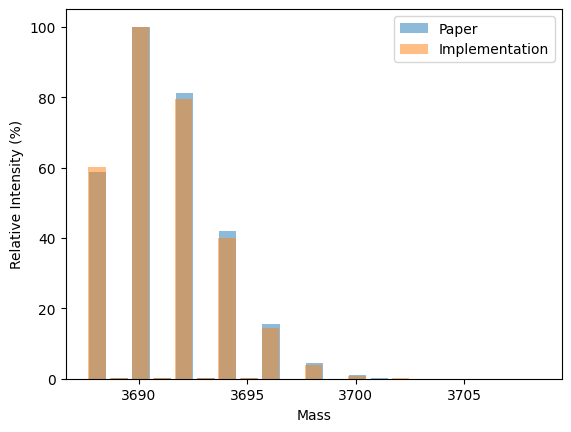

In [ ]:
import matplotlib.pyplot as plt
 
from alphapept.constants import isotopes
import numpy as np
from numba.typed import Dict
from numba import types

# Example from paper:
mass = 3688.1
abundances = np.array([58.83,0.18,100,0.29,81.29,0.22,42.05,0.11,15.54,0.04,4.36,0.01,0.97,0.17,0.03])/100
masses = [mass + i for i in range(len(abundances))]

# Calculation with own function
counted_AA = Dict.empty(key_type=types.unicode_type, value_type=types.int64)
counted_AA["K"] = 23
counted_AA["I"] = 22
dist = dict_to_dist(counted_AA, isotopes)
masses_ = [dist.m0 + i for i in range(len(dist.intensities))]

# Plot 
masses = [mass + i for i in range(len(abundances))]
plt.bar(masses, abundances*100, alpha=0.5, label='Paper')
plt.bar(masses_, dist.intensities*100, alpha=0.5, label='Implementation')
plt.xlabel('Mass')
plt.ylabel('Relative Intensity (%)')
plt.legend()
plt.show()

## Averagine

The averagine model is based on [Senko et al.](https://www.sciencedirect.com/science/article/pii/1044030595000178). We define the function [`get_average_formula`](https://mannlabs.github.io/alphapept/chem.html#get_average_formula) to calculate a dictionary with averagine masses.

In [5]:
#| echo: false
#| output: asis
show_doc(get_average_formula)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L178){target="_blank" style="float:right; font-size:smaller"}

### get_average_formula

>      get_average_formula (molecule_mass:float,
>                           averagine_aa:numba.typed.typeddict.Dict,
>                           isotopes:numba.typed.typeddict.Dict,
>                           sulphur:bool=True)

Function to calculate the averagine formula for a molecule mass.

Args:
    molecule_mass (float): Input molecule mass for which the averagine model should be calculated.
    averagine_aa (Dict): Numba-typed dictionary with averagine masses. See alphapept.constants.averagine_aa.
    isotopes (Dict): Numba-typed lookup dict with isotopes.
    sulphur (bool, optional): Flag to consider sulphur. Defaults to True.

Raises:
    NotImplementedError: If mode w/o sulphur is selected.

Returns:
    Dict: Numba-typed dict with averagine composition.

In [ ]:
from alphapept.constants import averagine_aa, averagine_avg

In [ ]:
molecule_mass = 300
print(get_average_formula(molecule_mass, averagine_aa, isotopes, sulphur=True))

{C: 13, H: 24, N: 4, O: 4, S: 0}


To directly calculate the isotope distribution of a molecule mass based on the averagine model, we define the wrapper function [`mass_to_dist`](https://mannlabs.github.io/alphapept/chem.html#mass_to_dist).

In [6]:
#| echo: false
#| output: asis
show_doc(mass_to_dist)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L219){target="_blank" style="float:right; font-size:smaller"}

### mass_to_dist

>      mass_to_dist (molecule_mass:float,
>                    averagine_aa:numba.typed.typeddict.Dict,
>                    isotopes:numba.typed.typeddict.Dict)

Function to calculate an isotope distribution from a molecule mass using the averagine model.

Args:
    molecule_mass (float, averagine_aa): input molecule mass.
    averagine_aa (Dict): Numba-typed dictionary with averagine masses.
    isotopes (Dict): Numba-typed lookup dict with isotopes.

Returns:
    np.ndarray: isotope masses.
    np.ndarray: isotope intensity.

In [ ]:
print(mass_to_dist(300, averagine_aa, isotopes))

(array([300.18252563, 301.18539427, 302.18826291, 303.19113155,
       304.19400019, 305.19686883]), array([1.00000000e+00, 1.59501684e-01, 2.01508986e-02, 1.86370995e-03,
       1.39934810e-04, 8.55900106e-06]))


We can use this to plot isotope distributions for a given mass.

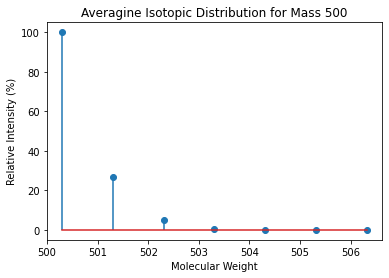

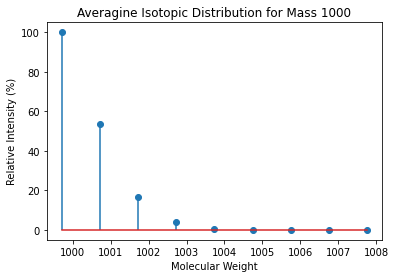

In [ ]:
def plot_averagine(mass, averagine_aa, isotopes):

    masses, intensity = mass_to_dist(mass, averagine_aa, isotopes)
    plt.title("Averagine Isotopic Distribution for Mass {}".format(mass))
    plt.stem(masses, intensity*100, use_line_collection=True)
    plt.ylabel("Relative Intensity (%)")
    plt.xlabel("Molecular Weight")
    plt.show()

plot_averagine(500, averagine_aa, isotopes)
plot_averagine(1000, averagine_aa, isotopes)

## Mass Calculations
[`calculate_mass`](https://mannlabs.github.io/alphapept/chem.html#calculate_mass): This function allows to calculate the precursor mass from the monoisotopic m/z and the charge.

In [7]:
#| echo: false
#| output: asis
show_doc(calculate_mass)

---

[source](https://github.com/mannlabs/alphapept/blob/master/alphapept/chem.py#L246){target="_blank" style="float:right; font-size:smaller"}

### calculate_mass

>      calculate_mass (mono_mz:float, charge:int)

Calculate the precursor mass from mono mz and charge.

Args:
    mono_mz (float): mono m/z.
    charge (int): charge.

Returns:
    float: precursor mass.

In [ ]:
mz = 300
charge = 2

print(calculate_mass(mz, charge))

597.98544706626
